In [1]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
%matplotlib inline

In [2]:
FEATURE_DIR = "data/gmm_benchmark"  # <- change if needed
LABELED_CSV = os.path.join(FEATURE_DIR, "features_master_labeled_gmm4.csv")
OUT_DIR = os.path.join(FEATURE_DIR, "gmm_validation")
os.makedirs(OUT_DIR, exist_ok=True)

print("Loading:", LABELED_CSV)
df = pd.read_csv(LABELED_CSV)
print("Rows:", len(df))
print("Columns:", df.columns[:40].tolist())


Loading: data/gmm_benchmark\features_master_labeled_gmm4.csv
Rows: 35
Columns: ['file', 'player', 'n_samples', 'fs_used', 'gmm_label', 'gmm_confidence', 'performance_level', 'performance_level_confidence', '_proxy_score', 'Gastrocnemius left__dur_halfmax_s', 'Gastrocnemius left__iEMG', 'Gastrocnemius left__iEMG_rel', 'Gastrocnemius left__mdf', 'Gastrocnemius left__mnf', 'Gastrocnemius left__mrms_mean', 'Gastrocnemius left__mrms_mean_rel', 'Gastrocnemius left__mrms_peak', 'Gastrocnemius left__mrms_peak_rel', 'Gastrocnemius left__peak', 'Gastrocnemius left__peak_rel', 'Gastrocnemius left__rms', 'Gastrocnemius left__rms_rel', 'Gastrocnemius left__std', 'Gastrocnemius left__time_to_peak_s', 'Gastrocnemius left__wl', 'Gastrocnemius right__dur_halfmax_s', 'Gastrocnemius right__iEMG', 'Gastrocnemius right__iEMG_rel', 'Gastrocnemius right__mdf', 'Gastrocnemius right__mnf', 'Gastrocnemius right__mrms_mean', 'Gastrocnemius right__mrms_mean_rel', 'Gastrocnemius right__mrms_peak', 'Gastrocnemius r

Cluster counts:
gmm_label
0     5
1    10
2    18
3     2
Name: count, dtype: int64

GMM confidence (max posterior) summary:
count    35.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: gmm_confidence, dtype: float64


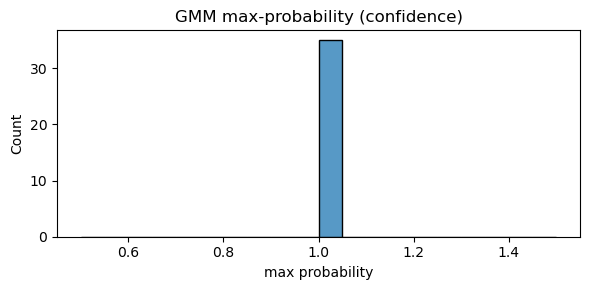

In [3]:
# Cell 2 - basic cluster counts and confidence overview
assert 'gmm_label' in df.columns, "gmm_label not found in dataframe"
print("Cluster counts:")
print(df['gmm_label'].value_counts().sort_index())

if 'gmm_confidence' in df.columns:
    print("\nGMM confidence (max posterior) summary:")
    print(df['gmm_confidence'].describe())
    # histogram
    plt.figure(figsize=(6,3))
    sns.histplot(df['gmm_confidence'].dropna(), bins=20)
    plt.title("GMM max-probability (confidence)")
    plt.xlabel("max probability")
    plt.tight_layout()
    plt.show()
else:
    print("No gmm_confidence column available.")


In [4]:
# Cell 3 - pick candidate features used for analysis (auto-detect)
# If you have a saved list of candidate_cols from GMM notebook, load that instead.
candidate_cols = [c for c in df.columns if any(kw in c.lower() for kw in ["__rms","__peak","__iemg","__mnf","__mdf",
                                                                            "__time_to_peak","__dur_halfmax","coact","lr_mean_ratio",
                                                                            "__mrms_mean","__mrms_peak","__std","__wl"])]
if len(candidate_cols) == 0:
    # fallback to numeric columns excluding metadata
    meta = {'file','player','n_samples','fs_used','gmm_label','gmm_confidence','performance_level','performance_level_confidence','_proxy_score'}
    candidate_cols = [c for c in df.columns if c not in meta and np.issubdtype(df[c].dtype, np.number)]
print("Using candidate features count:", len(candidate_cols))
print(candidate_cols[:40])


Using candidate features count: 136
['Gastrocnemius left__dur_halfmax_s', 'Gastrocnemius left__iEMG', 'Gastrocnemius left__iEMG_rel', 'Gastrocnemius left__mdf', 'Gastrocnemius left__mnf', 'Gastrocnemius left__mrms_mean', 'Gastrocnemius left__mrms_mean_rel', 'Gastrocnemius left__mrms_peak', 'Gastrocnemius left__mrms_peak_rel', 'Gastrocnemius left__peak', 'Gastrocnemius left__peak_rel', 'Gastrocnemius left__rms', 'Gastrocnemius left__rms_rel', 'Gastrocnemius left__std', 'Gastrocnemius left__time_to_peak_s', 'Gastrocnemius left__wl', 'Gastrocnemius right__dur_halfmax_s', 'Gastrocnemius right__iEMG', 'Gastrocnemius right__iEMG_rel', 'Gastrocnemius right__mdf', 'Gastrocnemius right__mnf', 'Gastrocnemius right__mrms_mean', 'Gastrocnemius right__mrms_mean_rel', 'Gastrocnemius right__mrms_peak', 'Gastrocnemius right__mrms_peak_rel', 'Gastrocnemius right__peak', 'Gastrocnemius right__peak_rel', 'Gastrocnemius right__rms', 'Gastrocnemius right__rms_rel', 'Gastrocnemius right__std', 'Gastrocnemiu

In [5]:
# Cell 4 - per-cluster summary of feature means & stds and save as JSON
cluster_summary = {}
for cl, grp in df.groupby('gmm_label'):
    summary = {
        "n": int(len(grp)),
        "confidence_mean": float(grp['gmm_confidence'].mean()) if 'gmm_confidence' in grp else None,
        "confidence_std": float(grp['gmm_confidence'].std()) if 'gmm_confidence' in grp else None,
        "proxy_mean": float(grp['_proxy_score'].mean()) if '_proxy_score' in grp else None,
        "proxy_std": float(grp['_proxy_score'].std()) if '_proxy_score' in grp else None,
        "feature_means": {},
        "feature_stds": {}
    }
    for c in candidate_cols:
        summary['feature_means'][c] = None if grp[c].dropna().size==0 else float(grp[c].mean())
        summary['feature_stds'][c] = None if grp[c].dropna().size==0 else float(grp[c].std())
    cluster_summary[int(cl)] = summary

# save
summary_path = os.path.join(OUT_DIR, "cluster_feature_summary.json")
with open(summary_path, "w") as f:
    json.dump(cluster_summary, f, indent=2)
print("Saved cluster feature summary to:", summary_path)


Saved cluster feature summary to: data/gmm_benchmark\gmm_validation\cluster_feature_summary.json


In [6]:
# Cell 5 - cluster validity metrics (computed only when possible)
X = df[candidate_cols].copy().fillna(df[candidate_cols].median()).values
labels = df['gmm_label'].values
valid_metrics = {}
n_samples = X.shape[0]
n_clusters = len(np.unique(labels))
print("n_samples:", n_samples, "n_clusters:", n_clusters)

# Silhouette requires n_clusters >=2 and < n_samples
try:
    if n_clusters >= 2 and n_samples > n_clusters:
        s = silhouette_score(X, labels)
        valid_metrics['silhouette'] = float(s)
        print("Silhouette score:", s)
    else:
        print("Skipping silhouette: need at least 2 clusters and more samples than clusters.")
except Exception as e:
    print("Silhouette compute error:", e)

# Davies-Bouldin requires n_clusters >=2
try:
    if n_clusters >= 2:
        db = davies_bouldin_score(X, labels)
        valid_metrics['davies_bouldin'] = float(db)
        print("Davies-Bouldin score:", db)
    else:
        print("Skipping Davies-Bouldin: need at least 2 clusters.")
except Exception as e:
    print("Davies-Bouldin compute error:", e)

# Calinski-Harabasz requires n_clusters >=2
try:
    if n_clusters >= 2:
        ch = calinski_harabasz_score(X, labels)
        valid_metrics['calinski_harabasz'] = float(ch)
        print("Calinski-Harabasz score:", ch)
    else:
        print("Skipping Calinski-Harabasz: need at least 2 clusters.")
except Exception as e:
    print("Calinski-Harabasz compute error:", e)

# save metrics
with open(os.path.join(OUT_DIR, "cluster_validity_metrics.json"), "w") as f:
    json.dump(valid_metrics, f, indent=2)
print("Saved cluster validity metrics to:", os.path.join(OUT_DIR, "cluster_validity_metrics.json"))


n_samples: 35 n_clusters: 4
Silhouette score: 0.2044001557189045
Davies-Bouldin score: 1.8701715175307299
Calinski-Harabasz score: 31.289764512939385
Saved cluster validity metrics to: data/gmm_benchmark\gmm_validation\cluster_validity_metrics.json


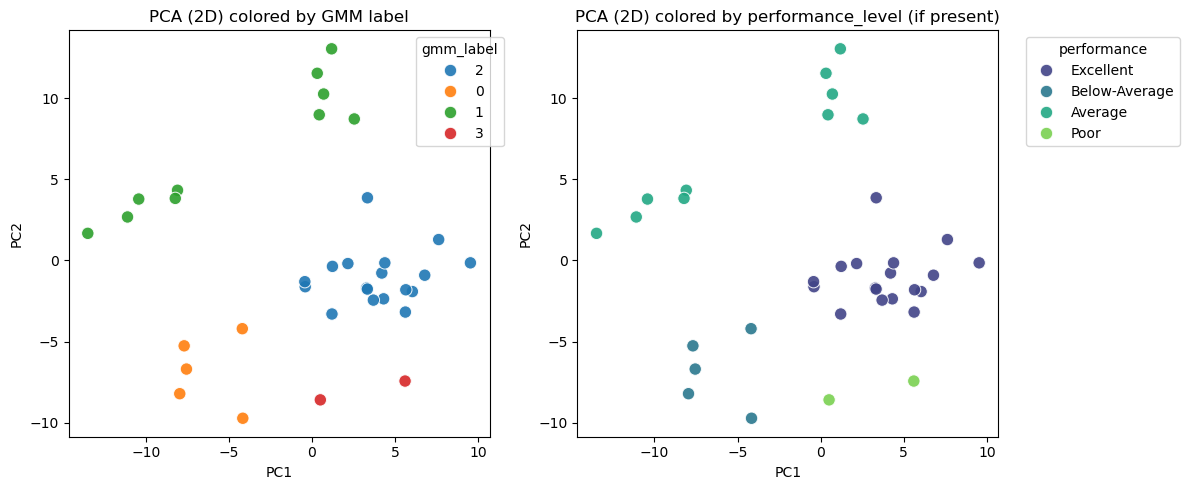

Saved PCA scatter to: data/gmm_benchmark\gmm_validation\pca_scatter.png


In [7]:
# Cell 6 - PCA scatterplot colored by cluster and by performance_level (two panels)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca = PCA(n_components=2)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df['gmm_label'].astype(str), palette='tab10', s=80, alpha=0.9)
plt.title("PCA (2D) colored by GMM label")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="gmm_label", bbox_to_anchor=(1.05,1))

plt.subplot(1,2,2)
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df.get('performance_level', df['gmm_label']).astype(str), palette='viridis', s=80, alpha=0.9)
plt.title("PCA (2D) colored by performance_level (if present)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="performance", bbox_to_anchor=(1.05,1))

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_scatter.png"), bbox_inches='tight', dpi=200)
plt.show()
print("Saved PCA scatter to:", os.path.join(OUT_DIR, "pca_scatter.png"))


In [8]:
# Cell 7 - per-cluster examples: top by confidence and bottom by confidence & top/bottom by proxy_score
def sample_examples(grp, keep=3):
    out = {}
    if 'gmm_confidence' in grp.columns:
        out['top_by_conf'] = grp.sort_values('gmm_confidence', ascending=False).head(keep)[['file','player','gmm_confidence','_proxy_score']].to_dict(orient='records')
        out['bottom_by_conf'] = grp.sort_values('gmm_confidence', ascending=True).head(keep)[['file','player','gmm_confidence','_proxy_score']].to_dict(orient='records')
    else:
        out['top_by_conf'] = []
        out['bottom_by_conf'] = []
    if '_proxy_score' in grp.columns:
        out['top_by_proxy'] = grp.sort_values('_proxy_score', ascending=False).head(keep)[['file','player','_proxy_score','gmm_confidence']].to_dict(orient='records')
        out['bottom_by_proxy'] = grp.sort_values('_proxy_score', ascending=True).head(keep)[['file','player','_proxy_score','gmm_confidence']].to_dict(orient='records')
    else:
        out['top_by_proxy'] = []; out['bottom_by_proxy'] = []
    return out

examples = {}
for cl, grp in df.groupby('gmm_label'):
    examples[int(cl)] = sample_examples(grp, keep=3)

examples_path = os.path.join(OUT_DIR, "cluster_examples.json")
with open(examples_path, "w") as f:
    json.dump(examples, f, indent=2)
print("Saved per-cluster example files to:", examples_path)


Saved per-cluster example files to: data/gmm_benchmark\gmm_validation\cluster_examples.json


In [9]:
# Cell 8 - outlier detection inside clusters (zscore thresholding on candidate features)
from scipy.stats import zscore
outliers = {}
z_thresh = 3.0
for cl, grp in df.groupby('gmm_label'):
    sub = grp[candidate_cols].copy()
    sub = sub.fillna(sub.median())
    zs = np.abs(zscore(sub, nan_policy='omit'))
    # if only one feature, zs will be 1D
    if zs.ndim == 1:
        bad_idx = np.where(zs > z_thresh)[0]
    else:
        bad_idx = np.where((zs > z_thresh).any(axis=1))[0]
    outlier_files = grp.iloc[bad_idx]['file'].tolist()
    outliers[int(cl)] = {"n_outliers": int(len(outlier_files)), "files": outlier_files}
outliers_path = os.path.join(OUT_DIR, "cluster_outliers.json")
with open(outliers_path, "w") as f:
    json.dump(outliers, f, indent=2)
print("Saved outlier listing to:", outliers_path)


Saved outlier listing to: data/gmm_benchmark\gmm_validation\cluster_outliers.json


C:\Users\LaukikS\AppData\Local\Temp\ipykernel_4640\4152051300.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zs = np.abs(zscore(sub, nan_policy='omit'))
C:\Users\LaukikS\AppData\Local\Temp\ipykernel_4640\4152051300.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zs = np.abs(zscore(sub, nan_policy='omit'))
C:\Users\LaukikS\AppData\Local\Temp\ipykernel_4640\4152051300.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zs = np.abs(zscore(sub, nan_policy='omit'))
C:\Users\LaukikS\AppData\Local\Temp\ipykernel_4640\4152051300.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastro

In [10]:
# Cell 9 - textual guidance + human checks summary (print)
print("\n--- HUMAN CHECK LIST ---")
print("1) Are cluster sizes reasonable? (each cluster >= ~10 samples ideal)")
print("   Cluster counts:", df['gmm_label'].value_counts().to_dict())
print("2) Are cluster confidences high? mean confidence per cluster saved in cluster_feature_summary.json")
print("3) PCA plot saved to visualize separability:", os.path.join(OUT_DIR, "pca_scatter.png"))
print("4) Check cluster_examples.json for representative trials to play/inspect.")
print("5) If many singleton clusters or low confidences (<0.6), do NOT use these clusters as final benchmarks until more data.")
print("6) If clusters look reasonable, proceed to train ML models using performance_level as target.")
print("\nValidation artifacts saved in:", OUT_DIR)
print(" - cluster_feature_summary.json")
print(" - cluster_validity_metrics.json")
print(" - pca_scatter.png")
print(" - cluster_examples.json")
print(" - cluster_outliers.json")



--- HUMAN CHECK LIST ---
1) Are cluster sizes reasonable? (each cluster >= ~10 samples ideal)
   Cluster counts: {2: 18, 1: 10, 0: 5, 3: 2}
2) Are cluster confidences high? mean confidence per cluster saved in cluster_feature_summary.json
3) PCA plot saved to visualize separability: data/gmm_benchmark\gmm_validation\pca_scatter.png
4) Check cluster_examples.json for representative trials to play/inspect.
5) If many singleton clusters or low confidences (<0.6), do NOT use these clusters as final benchmarks until more data.
6) If clusters look reasonable, proceed to train ML models using performance_level as target.

Validation artifacts saved in: data/gmm_benchmark\gmm_validation
 - cluster_feature_summary.json
 - cluster_validity_metrics.json
 - pca_scatter.png
 - cluster_examples.json
 - cluster_outliers.json
